In [14]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import folium 
from datetime import datetime
from math import sin, cos, sqrt, atan2, radians
import sqlite3
import requests
import geopandas as gpd
from utils import get_osrm_distance 
import requests
from pyproj import Transformer
import os

In [15]:
# Carica il dataset
data = pd.read_csv("ChargingStationCleaned.csv")

# Aggiungi una colonna con l'anno di costruzione
data['year'] = pd.to_datetime(data['commissioning_date']).dt.year

# Correggi i nomi dei Land con umlaut
data['federal_state'] = data['federal_state'].replace({"Baden-Wï¿½rttemberg": "Baden-Württemberg",
                                                        "Thï¿½ringen": "Thüringen"})

In [16]:
data.columns

Index(['operator', 'address', 'house_number', 'placeholder1', 'postcode',
       'city', 'federal_state', 'metropolitan_area', 'latitude_[dg]',
       'longitude_[dg]', 'commissioning_date', 'power_connection_[kw]',
       'type_of_charger', 'number_of_charging_points', 'type_of_plug_1',
       'p1_[kw]', 'type_of_plug_2', 'p2_[kw]', 'type_of_plug_3', 'p3_[kw]',
       'type_of_plug_4', 'p4_[kw]', 'year'],
      dtype='object')

In [17]:
# Punto 1: Numero di connettori per Land e anno, divisi tra Normal e Fast (cumulative)

# Calcola il numero di connettori per Land, anno e tipo di caricabatterie
conn_by_land_year = data.groupby(['federal_state', 'year', 'type_of_charger']).size().reset_index(name='count')

# Calcola i valori cumulativi
conn_by_land_year['cumulative_count'] = conn_by_land_year.groupby(['federal_state', 'type_of_charger'])['count'].cumsum()

# Calcola l'aumento percentuale rispetto all'anno precedente
conn_by_land_year['pct_change'] = conn_by_land_year.groupby(['federal_state', 'type_of_charger'])['cumulative_count'].pct_change() * 100

# Stampa il risultato
print("Punto 1: Numero di connettori per Land e anno, divisi tra Normal e Fast (cumulative)")
conn_by_land_year.to_excel('statistics_graphs/point_one.xlsx')

Punto 1: Numero di connettori per Land e anno, divisi tra Normal e Fast (cumulative)


In [18]:
# Punto 2: Potenza totale per Land di anno in anno e la potenza media (cumulativa)

# Calcola la potenza totale e la potenza media per Land, anno e tipo di caricabatterie
power_by_land_year = data.groupby(['federal_state', 'year', 'type_of_charger']).agg({'power_connection_[kw]': ['sum', 'mean']}).reset_index()
power_by_land_year.columns = ['federal_state', 'year', 'type_of_charger', 'total_power', 'avg_power']

# Calcola i valori cumulativi per la potenza totale
power_by_land_year['cumulative_total_power'] = power_by_land_year.groupby(['federal_state', 'type_of_charger'])['total_power'].cumsum()

# Calcola l'aumento percentuale rispetto all'anno precedente per la potenza totale cumulativa
power_by_land_year['pct_change_total_power'] = power_by_land_year.groupby(['federal_state', 'type_of_charger'])['cumulative_total_power'].pct_change() * 100

# Stampa il risultato
print("Punto 2: Potenza totale per Land di anno in anno e la potenza media (cumulativa)")
power_by_land_year.to_excel('statistics_graphs/point_two.xlsx')


Punto 2: Potenza totale per Land di anno in anno e la potenza media (cumulativa)


In [19]:
# Punto 3: Tipo di connettore per anno con aumento in percentuale per ogni anno

# Unisci tutte le colonne dei connettori
connector_columns = ['type_of_plug_1', 'type_of_plug_2', 'type_of_plug_3', 'type_of_plug_4']
data_melted = pd.melt(data, id_vars=['year'], value_vars=connector_columns, var_name='connector_column', value_name='connector_type').dropna()

# Separa i connettori con più prese
data_melted['connector_type'] = data_melted['connector_type'].apply(lambda x: x.split(', '))

# Espandi il DataFrame in modo che ogni presa abbia la sua riga
data_melted = data_melted.explode('connector_type')

# Calcola il conteggio cumulativo per ogni tipo di connettore e anno
connector_by_year = data_melted.groupby(['year', 'connector_type']).size().groupby('connector_type').cumsum().reset_index(name='count')

# Calcola l'aumento percentuale rispetto all'anno precedente
connector_by_year['pct_change'] = connector_by_year.groupby('connector_type')['count'].pct_change() * 100

# Stampa il risultato
print("\nPunto 3: Tipo di connettore per anno con aumento in percentuale per ogni anno")
connector_by_year.to_excel('statistics_graphs/point_three.xlsx')


Punto 3: Tipo di connettore per anno con aumento in percentuale per ogni anno


In [20]:
# Punto 4 aggiornato: Tabella con "Operator", "Connection Points" e "Charging Stations", ordinata secondo "Connection Points"

# Calcola il numero totale di stazioni di ricarica per produttore
top_operators_stations = data['operator'].value_counts().reset_index()
top_operators_stations.columns = ['operator', 'charging_stations']

# Unisci le due tabelle (connettore e stazioni) in base all'operatore
top_operators_combined = top_operators_stations.merge(top_operators_connectors, on='operator')

# Ordina la tabella combinata in base ai "Connection Points"
top_operators_combined = top_operators_combined.sort_values(by='count', ascending=False).head(5)

# Stampa il risultato
print("\nPunto 4 aggiornato: Tabella con 'Operator', 'Connection Points' e 'Charging Stations', ordinata secondo 'Connection Points'")
top_operators_combined.to_excel('statistics_graphs/point_four.xlsx')


NameError: name 'top_operators_connectors' is not defined

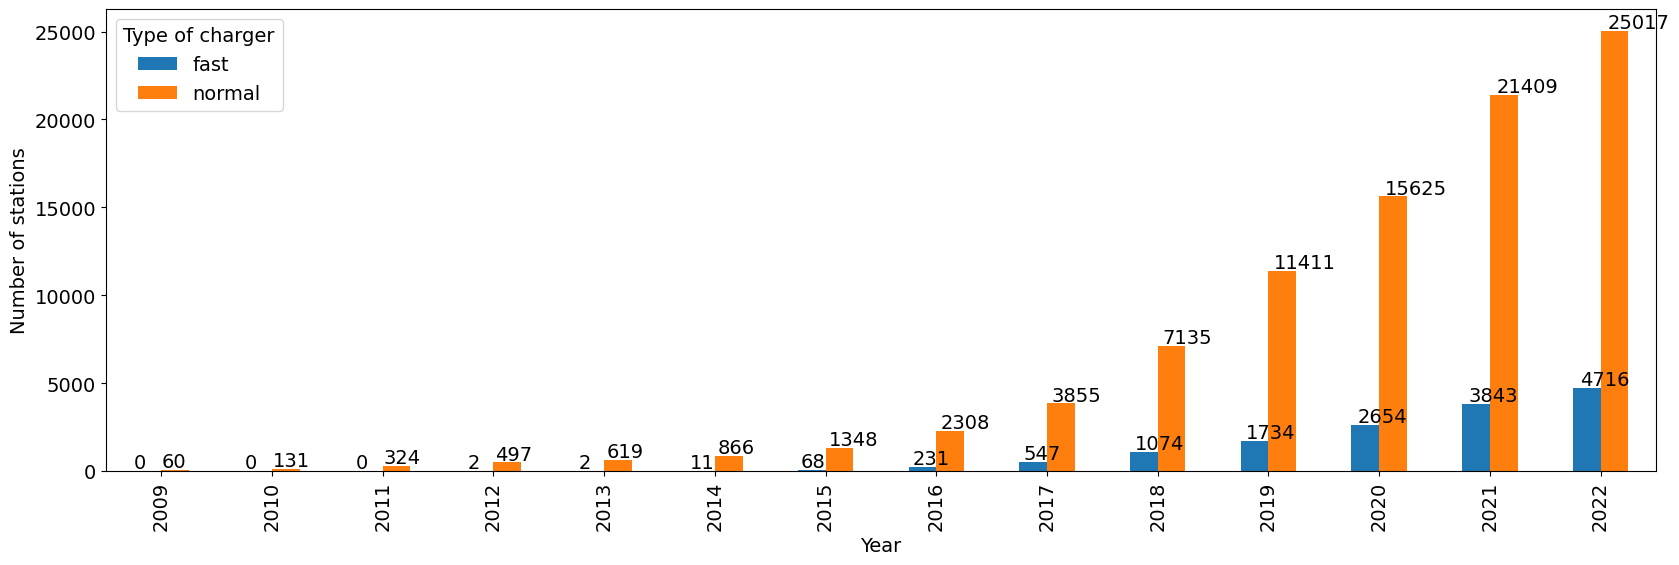

In [21]:
# Punto 5: Istogramma per anno con colonne Normal e Fast (cumulative)

# Prepara i dati per l'istogramma
hist_data = data.pivot_table(index='year', columns='type_of_charger', values='power_connection_[kw]', aggfunc='count').fillna(0)

# Calcola i valori cumulativi
hist_data_cumulative = hist_data.cumsum()

# Aggiungi gli anni mancanti a partire dal 2009
hist_data_cumulative = hist_data_cumulative.reindex(range(2009, hist_data_cumulative.index.max()+1)).fillna(method='ffill')

# Modifica le dimensioni delle scritte globalmente
plt.rcParams['font.size'] = 14

# Crea l'istogramma
fig, ax = plt.subplots(figsize=(20, 6))
hist_data_cumulative.plot(kind='bar', stacked=False, ax=ax)
# plt.title("Istogramma per anno con colonne Normal e Fast (cumulative)")
plt.xlabel("Year")
plt.ylabel("Number of stations")
plt.legend(title="Type of charger")

# Aggiungi il numero di colonnine sopra le barre con una posizione leggermente più alta e visualizzalo come intero
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", (p.get_x() * 1.005, p.get_height() + 150))

# Salva il grafico nella cartella statistics_graphs con il nome point_five.png
plt.savefig("statistics_graphs/point_five.png", bbox_inches='tight')

plt.show()


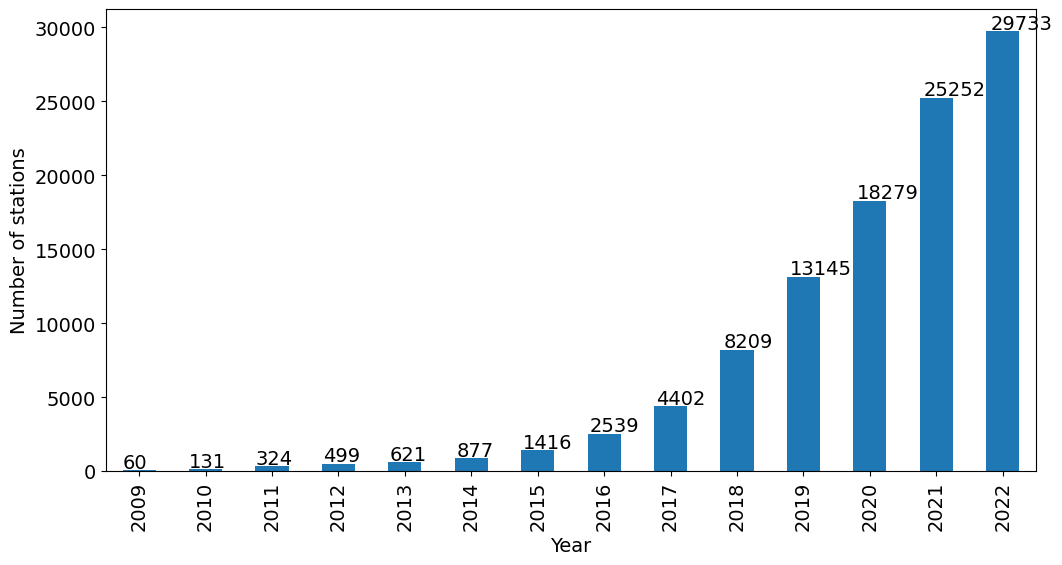

In [22]:
# Punto 6: Istogramma su tutta la Germania per anno con numero totale di charging station (cumulative)

total_charging_station_by_year = data['year'].value_counts().sort_index()

# Calcola i valori cumulativi
total_charging_station_by_year_cumulative = total_charging_station_by_year.cumsum()

# Aggiungi gli anni mancanti a partire dal 2009
total_charging_station_by_year_cumulative = total_charging_station_by_year_cumulative.reindex(range(2009, total_charging_station_by_year_cumulative.index.max()+1)).fillna(method='ffill')

# Modifica le dimensioni delle scritte globalmente
plt.rcParams['font.size'] = 14

# Imposta la dimensione della figura
plt.figure(figsize=(12, 6))

ax = total_charging_station_by_year_cumulative.plot(kind='bar')
# plt.title("Istogramma su tutta la Germania per anno con numero totale di charging station (cumulative)")
plt.xlabel("Year")
plt.ylabel("Number of stations")

# Aggiungi il numero di colonnine sopra le barre
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() * 1.005, p.get_height() + 150))

# Salva il grafico nella cartella statistics_graphs con il nome point_six.png
plt.savefig("statistics_graphs/point_six.png", bbox_inches='tight')

plt.show()

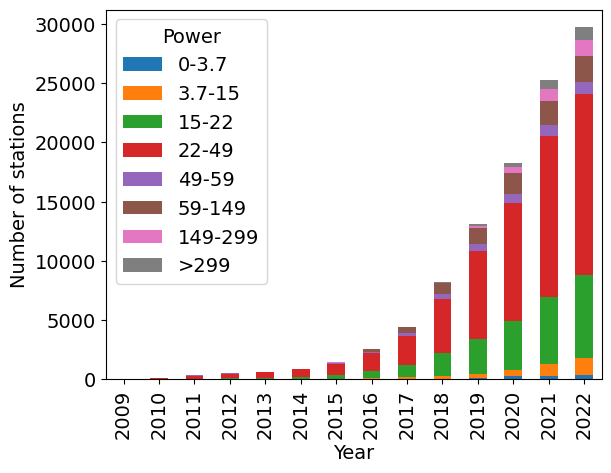

In [27]:
# Punto 7: Istogramma con colonne per ogni anno e clustering di potenza (cumulative)

# Definisci le fasce di potenza
bins = [0, 3.7, 15, 22, 49, 59, 149, 299, np.inf]
labels = ['0-3.7', '3.7-15', '15-22', '22-49', '49-59', '59-149', '149-299', '>299']

# Crea una nuova colonna per le fasce di potenza
data['power_range'] = pd.cut(data['power_connection_[kw]'], bins=bins, labels=labels)

# Calcola il conteggio per ogni anno e fascia di potenza
power_range_by_year = data.groupby(['year', 'power_range']).size().unstack().fillna(0)

# Calcola i valori cumulativi
power_range_by_year_cumulative = power_range_by_year.cumsum()

# Aggiungi gli anni mancanti a partire dal 2009
power_range_by_year_cumulative = power_range_by_year_cumulative.reindex(range(2009, power_range_by_year_cumulative.index.max()+1)).fillna(method='ffill')

# Modifica le dimensioni delle scritte globalmente
plt.rcParams['font.size'] = 14

# Crea l'istogramma
ax = power_range_by_year_cumulative.plot(kind='bar', stacked=True)

# plt.title("Istogramma con colonne per ogni anno e clustering di potenza (cumulative)")
plt.xlabel("Year")
plt.ylabel("Number of stations")
plt.legend(title="Power")

# Salva il grafico nella cartella statistics_graphs con il nome point_seven.png
plt.savefig("statistics_graphs/point_seven.png", bbox_inches='tight')

plt.show()

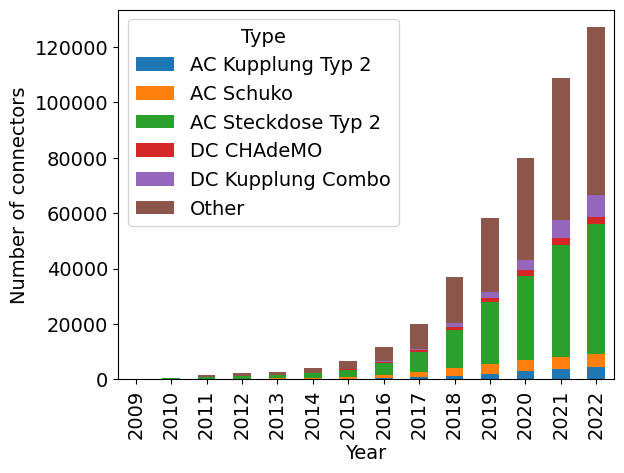

In [29]:
# Funzione per raggruppare i tipi di connettore
def cluster_connector(connector):
    if 'AC Steckdose Typ 2' in connector:
        return 'AC Steckdose Typ 2'
    elif 'AC Kupplung Typ 2' in connector:
        return 'AC Kupplung Typ 2'
    elif 'DC Kupplung Combo' in connector:
        return 'DC Kupplung Combo'
    elif 'AC Schuko' in connector:
        return 'AC Schuko'
    elif 'DC CHAdeMO' in connector:
        return 'DC CHAdeMO'
    else:
        return 'Other'

# Funzione per dividere le stringhe con virgole e rimuovere spazi vuoti
def split_connector(connector):
    if connector is not None and connector.strip() != '' and ',' in connector:
        return [c.strip() for c in connector.split(',')]
    elif connector is not None and connector.strip() != '':
        return [connector.strip()]
    else:
        return []

# Crea una lista vuota per contenere i dati elaborati
data_processed = []

# Itera attraverso ogni riga di dati e applica la funzione split_connector
for index, row in data.iterrows():
    for column in connector_columns:
        connector_list = split_connector(row[column])
        for connector in connector_list:
            if connector is not None and connector != '':  # Aggiungi solo righe con connettori non vuoti
                data_processed.append({'year': row['year'], 'connector_type': connector})

# Crea un nuovo DataFrame con i dati elaborati
data_processed_df = pd.DataFrame(data_processed)

# Applica la funzione per raggruppare i tipi di connettore
data_processed_df['connector_cluster'] = data_processed_df['connector_type'].apply(cluster_connector)

# Calcola il conteggio cumulativo per ogni anno e cluster di connettore
connector_cluster_by_year_hist = data_processed_df.groupby(['year', 'connector_cluster']).size().unstack().fillna(0).cumsum()

# Filtra il DataFrame per includere solo gli anni dal 2009 in poi
connector_cluster_by_year_hist = connector_cluster_by_year_hist[connector_cluster_by_year_hist.index >= 2009]

# Modifica le dimensioni delle scritte globalmente
plt.rcParams['font.size'] = 14

# Crea l'istogramma
ax = connector_cluster_by_year_hist.plot(kind='bar', stacked=True)

# ax.set_xlim(left=2009)

# plt.title("Istogramma cumulativo con colonne per ogni anno e tipo di connettore raggruppati nei cluster specificati")
plt.xlabel("Year")
plt.ylabel("Number of connectors")
plt.legend(title="Type")

plt.show()


In [25]:
# # Ottieni i valori unici presenti nella colonna "Other"
# other_connectors = data_melted[data_melted['connector_cluster'] == 'Other']['connector_type'].unique()

# # Stampa i valori unici
# print("Tipi di connettori raggruppati in 'Other':")
# for connector in other_connectors:
#     print(connector)


In [26]:
# # Calcola il conteggio per ciascun tipo di connettore nella colonna "Other"
# other_connectors_count = data_melted[data_melted['connector_cluster'] == 'Other']['connector_type'].value_counts()

# # Stampa il conteggio
# print("Frequenza dei tipi di connettori raggruppati in 'Other':")
# print(other_connectors_count)
